# VGG

### 经典卷积神经网络基本组成：
- 带填充以保持分辨率的卷积层
- 非线性激活函数，如ReLU
- 池化层，如最大池化层  

VGG块与之类似，由一系列卷积层组成


### 选项
- 更多的全连接层（太贵）
- 更多的卷积层
- 将卷积层组合成块

### VGG块
- 深VS.宽？
  - $5\times5$卷积
  - $3\times3$卷积
  - **深但窄**效果更好
- VGG块
  - $3\times3$（填充1）（n层，m通道）
  - $2\times2$最大池化层（步幅2）

### VGG架构
- 多个VGG块后接全连接层
- 不同次数的重复得到不同的架构VGG-16,VGG-19...

### 进度
- LeNet
  - 2卷积 + 池化层
  - 2全连接层
- AlexNet
  - 更大更深
  - ReLU，Dropout，数据增强
- VGG
  - 更大更深的AlexNet（重复VGG块）

### 总结
- VGG使用**可重复使用的卷积块**来构建深度卷积神经网络
- 不同的卷积块个数和超参数可以得到不同程度的变种

## 代码

In [1]:
! pip install d2l

**VGG块**
- 三个参数：卷积层数量，输入通道数，输出通道数
- **高宽减半+通道数加倍**

In [2]:
import torch

from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
  layers = []
  for _ in range(num_convs):
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)) # 高宽不变
    layers.append(nn.ReLU())
    in_channels = out_channels
  layers.append(nn.MaxPool2d(kernel_size=2, stride=2)) # 高宽减半
  return nn.Sequential(*layers)

**VGG网络**
- 如下构造VGG-11

In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2,512))

def vgg(conv_arch):
  conv_blks = []
  in_channels = 1
  # 卷积层部分
  for (num_conv, out_channels) in conv_arch:
    conv_blks.append(vgg_block(num_conv, in_channels, out_channels))
    in_channels = out_channels

  return nn.Sequential(
      *conv_blks, nn.Flatten(),
      # 全连接层部分
      nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
      nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
      nn.Linear(4096, 10)
  )

net = vgg(conv_arch)

可以看到：卷积层——高宽减半，通道数加倍

In [4]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 训练

由于VGG-11比AlexNet计算量更大，因此构建了一个**通道数较少**的网络，足够训练`Fashion-MNST`数据集

In [5]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.179, train acc 0.933, test acc 0.918
797.2 examples/sec on cuda:0


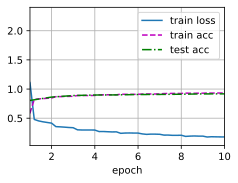

In [6]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## **练习！**


In [9]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
  layer = []
  for _ in range(num_convs):
    layer.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    layer.append(nn.ReLU())
    in_channels = out_channels
  layer.append(nn.MaxPool2d(kernel_size=2, stride=2))
  return nn.Sequential(*layer)

def vgg(conv_arch):
  conv_blks = []
  in_channels = 1
  for (num_convs, out_channels) in conv_arch:
    conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
    in_channels = out_channels

  return nn.Sequential(
      *conv_blks, nn.Flatten(),
      nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
      nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
      nn.Linear(4096, 10))

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
net = vgg(conv_arch)

X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
  X = blk(X)
  print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


**VGG-11**：8个卷积层，3个全连接层

In [10]:
X = torch.randn(size=(1, 1, 224, 224))

def print_net(net):
  global X
  for blk in net:
    if blk.__class__.__name__ == 'Sequential':
      print_net(blk)
      print()
    else:
      X = blk(X)
      print(blk.__class__.__name__, 'output shape:\t',X.shape)

print_net(net)

Conv2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
MaxPool2d output shape:	 torch.Size([1, 64, 112, 112])

Conv2d output shape:	 torch.Size([1, 128, 112, 112])
ReLU output shape:	 torch.Size([1, 128, 112, 112])
MaxPool2d output shape:	 torch.Size([1, 128, 56, 56])

Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
MaxPool2d output shape:	 torch.Size([1, 256, 28, 28])

Conv2d output shape:	 torch.Size([1, 512, 28, 28])
ReLU output shape:	 torch.Size([1, 512, 28, 28])
Conv2d output shape:	 torch.Size([1, 512, 28, 28])
ReLU output shape:	 torch.Size([1, 512, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 512, 14, 14])

Conv2d output shape:	 torch.Size([1, 512, 14, 14])
ReLU output shape:	 torch.Size([1, 512, 14, 14])
Conv2d output shape:	 torch.Size([1, 512, 14, 14])
ReLU output shape:	 to

2，  尝试将Fashion-MNIST数据集图像的高度和宽度从224改为96，这对实验有什么影响？
- `resize=96`
- 准确率降低（图像信息丢失），训练时间缩短。内存占用减少

loss 0.222, train acc 0.919, test acc 0.908
3687.6 examples/sec on cuda:0


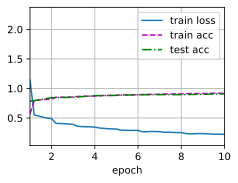

In [11]:
import torch
from torch import nn
from d2l import torch as d2l


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(1152, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())


3. 构造VGG的其他模型，如VG-16或VGG-19

In [12]:
def vgg_block(num_convs, in_channels, out_channels):
  layer = []
  for _ in range(num_convs):
    layer.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    layer.append(nn.ReLU())
    in_channels = out_channels
  layer.append(nn.MaxPool2d(kernel_size=2, stride=2))
  return nn.Sequential(*layer)

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

conv_arch = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))
net16 = vgg(conv_arch)

In [13]:
X = torch.randn(size=(1, 1, 224, 224))
def print_net(net):
    global X
    for blk in net:
        if blk.__class__.__name__ == "Sequential":
            print_net(blk)
            print()
        else:
            X = blk(X)
            print(blk.__class__.__name__,'output shape:\t',X.shape)
print_net(net16)

Conv2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
Conv2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
MaxPool2d output shape:	 torch.Size([1, 64, 112, 112])

Conv2d output shape:	 torch.Size([1, 128, 112, 112])
ReLU output shape:	 torch.Size([1, 128, 112, 112])
Conv2d output shape:	 torch.Size([1, 128, 112, 112])
ReLU output shape:	 torch.Size([1, 128, 112, 112])
MaxPool2d output shape:	 torch.Size([1, 128, 56, 56])

Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
MaxPool2d output shape:	 torch.Size([1, 256, 28, 28])

Conv2d output shape:	 torch.Size([1, 512, 28, 28])
ReLU output shape:	 torch.Size([1, 512, 28, 28])
Conv2d output shape:	 

In [16]:
conv_arch = ((2, 64), (2, 128), (4, 256), (4, 512), (4, 512))
net19 = vgg(conv_arch)

X = torch.randn(size=(1, 1, 224, 224))
print_net(net19)

Conv2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
Conv2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
MaxPool2d output shape:	 torch.Size([1, 64, 112, 112])

Conv2d output shape:	 torch.Size([1, 128, 112, 112])
ReLU output shape:	 torch.Size([1, 128, 112, 112])
Conv2d output shape:	 torch.Size([1, 128, 112, 112])
ReLU output shape:	 torch.Size([1, 128, 112, 112])
MaxPool2d output shape:	 torch.Size([1, 128, 56, 56])

Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
MaxPool2d output shape:	 torch.Size([1, 256, 28, 28])

Conv2d output shape:	 